In [132]:
import json
import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon
from shapely.affinity import scale
import matplotlib.pyplot as plt

import glob
import os
import datetime

# Loading dataframes

In [141]:
df_as_bids = pd.read_csv('FinalData/df_as_bid_aggregated_data.csv')
df_as_plan = pd.read_csv('FinalData/df_as_plan.csv')
df_as_prices = pd.read_csv('FinalData/df_AS_price_vol.csv')
df_energy_prices = pd.read_csv('FinalData/df_energy_price.csv')
df_gen = pd.read_csv('FinalData/df_generation.csv')
df_weather = pd.read_csv('FinalData/df_weather_forecast_ercot.csv')

In [142]:
df_dict = {}
dfs = [df_as_bids, df_as_plan, df_as_prices, df_energy_prices, df_gen, df_weather]
names = ["df_as_bids", "df_as_plan", "df_as_prices", "df_energy_prices", "df_gen", "df_weather"]
for i,df in enumerate(dfs):
    df_dict[names[i]] = df

In [143]:
for key in df_dict.keys():
    df_dict[key]['date'] = pd.to_datetime(df_dict[key]['date']).dt.date

In [144]:
for key in df_dict.keys():
    df_dict[key] = df_dict[key].sort_values(by=['date','hr_beg']).reset_index(drop=True)

# Intro plotting
* Just a week of data, to get used to what it looks like: 5/1/17 - 5/8/17
* Just regulation (up and down)

In [145]:
df_dict['df_as_bids'].head(1)

,date,hr_beg,OFFNS_Unweighted Average Price,OFFNS_Max Price,OFFNS_Min Price,OFFNS_Total Quantity,OFFNS_Number of Bids,OFFNS_Weighted Avg Price,ONNS_Unweighted Average Price,ONNS_Max Price,ONNS_Min Price,ONNS_Total Quantity,ONNS_Number of Bids,ONNS_Weighted Avg Price,REGDN_Unweighted Average Price,REGDN_Max Price,REGDN_Min Price,REGDN_Total Quantity,REGDN_Number of Bids,REGDN_Weighted Avg Price,REGUP_Unweighted Average Price,REGUP_Max Price,REGUP_Min Price,REGUP_Total Quantity,REGUP_Number of Bids,REGUP_Weighted Avg Price,RRSGN_Unweighted Average Price,RRSGN_Max Price,RRSGN_Min Price,RRSGN_Total Quantity,RRSGN_Number of Bids,RRSGN_Weighted Avg Price,RRSNC_Unweighted Average Price,RRSNC_Max Price,RRSNC_Min Price,RRSNC_Total Quantity,RRSNC_Number of Bids,RRSNC_Weighted Avg Price
0,2014-01-01,0,43.319091,300.01,0.01,38144.7,22,59.51279,22.01697,250.0,1.0,32531.5,33,36.74239,20.669077,500.0,0.92,71971.6,65,26.577483,19.744255,500.0,0.01,56916.8,47,27.332641,20.857083,500.0,0.01,107723.6,48,30.19552,1.5,3.0,0.0,2236.8,2,1.599651


In [146]:
df_dict['df_as_plan'].head(1)

,date,hr_beg,NSPIN_Quantity,REGDN_Quantity,REGUP_Quantity,RRS_Quantity
0,2016-01-01,0,915,293,280,2808


In [147]:
df_dict['df_as_prices'].head(1)

,date,hr_beg,price_DAH_Down Regulation,vol_DAH_Down Regulation,price_DAH_Up Regulation,vol_DAH_Up Regulation,price_DAH_Non-Spinning Reserve,vol_DAH_Non-Spinning Reserve,price_DAH_Responsive Reserve,vol_DAH_Responsive Reserve
0,2014-01-01,00:00:00,5.65,319.0,9.72,355.0,1.0,1500.0,11.72,2800.0


## Plotting prices, part 1

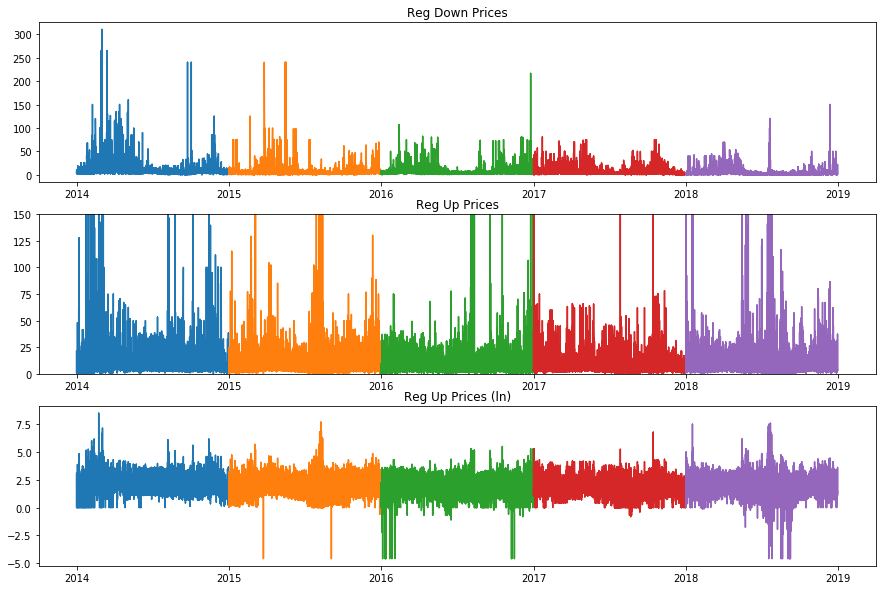

In [255]:
fig = plt.figure(figsize = (15,10))
plt.subplot(311)
for year in [2014,2015,2016,2017,2018]:
    plot_prices = df_dict['df_as_prices'].loc[(df_dict['df_as_prices']['date']>=datetime.date(year,1,1)) &
                                     (df_dict['df_as_prices']['date']<=datetime.date(year,12,31)),:]
    plt.plot(plot_prices['date'], plot_prices.iloc[:,2], label="year")
    plt.title("Reg Down Prices")

plt.subplot(312)
for year in [2014,2015,2016,2017,2018]:
    plot_prices = df_dict['df_as_prices'].loc[(df_dict['df_as_prices']['date']>=datetime.date(year,1,1)) &
                                     (df_dict['df_as_prices']['date']<=datetime.date(year,12,31)),:]
    plt.plot(plot_prices['date'], plot_prices.iloc[:,4], label="year")
    plt.title("Reg Up Prices")
    plt.ylim([0,150])
    
plt.subplot(313)
for year in [2014,2015,2016,2017,2018]:
    plot_prices = df_dict['df_as_prices'].loc[(df_dict['df_as_prices']['date']>=datetime.date(year,1,1)) &
                                     (df_dict['df_as_prices']['date']<=datetime.date(year,12,31)),:]
    plt.plot(plot_prices['date'], np.log(plot_prices.iloc[:,4]), label="year")
    plt.title("Reg Up Prices (ln)")

## Plotting bids

In [207]:
plot_prices = df_dict['df_as_prices'].loc[(df_dict['df_as_prices']['date']>=datetime.date(2017,5,1)) &
                                     (df_dict['df_as_prices']['date']<datetime.date(2017,5,8)),:]
plot_prices = plot_prices.loc[:,plot_prices.columns[np.r_[0,1,2,4]]].reset_index(drop=True)

In [208]:
plot_bids = df_dict['df_as_bids'].loc[(df_dict['df_as_bids']['date']>=datetime.date(2017,5,1)) &
                                     (df_dict['df_as_bids']['date']<datetime.date(2017,5,8)),:]

In [209]:
plot_bids_idx = plot_bids.loc[:,['date','hr_beg']]

In [210]:
plot_bids = plot_bids.loc[:,plot_bids.columns[14:26]]

In [211]:
plot_bids = pd.concat([plot_bids_idx, plot_bids], axis=1).reset_index(drop=True)

In [212]:
plot_bids['REGDN_Total Quantity'] = plot_bids['REGDN_Total Quantity']/10000
plot_bids['REGUP_Total Quantity'] = plot_bids['REGUP_Total Quantity']/10000

In [213]:
plot_bids['REGUP_Max Price'] = plot_bids['REGUP_Max Price']/1000

In [214]:
len(plot_bids)

168

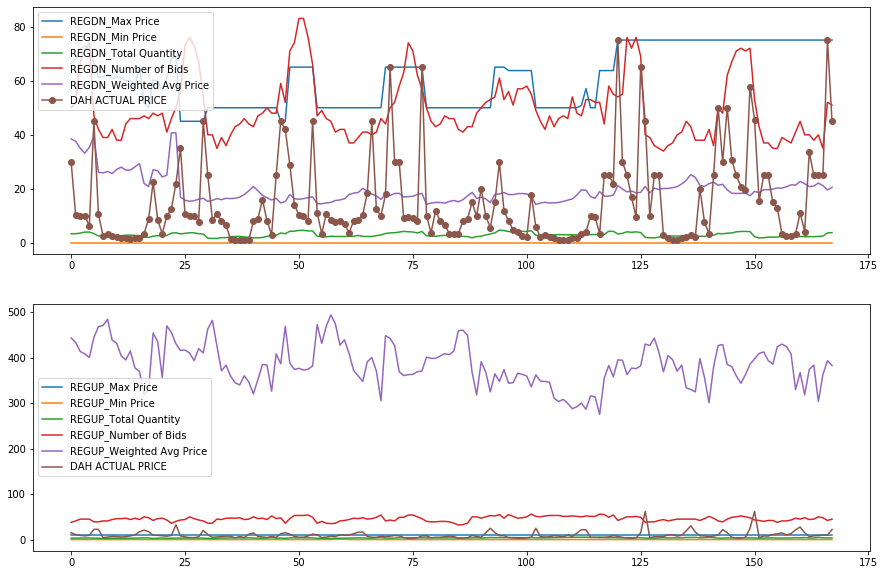

In [215]:
fig = plt.figure(figsize = (15,10))

plt.subplot(211)
for col in plot_bids.columns[3:8]:
    plt.plot(plot_bids[col], label=col)
plt.plot(plot_prices['price_DAH_Down Regulation'], marker='o', label='DAH ACTUAL PRICE')
plt.legend()

plt.subplot(212)
for col in plot_bids.columns[9:14]:
    plt.plot(plot_bids[col], label=col)
plt.plot(plot_prices['price_DAH_Up Regulation'], label='DAH ACTUAL PRICE')
plt.legend()

* read up on how to de-trend
* still need to check for seasonal component (ie, longer-term)
* make persistence model
* make avg model
* look at stats model

Notes:
* t is the x-variable, you dummy! and y is the regup. so your sin function has t in it
* we care about harmonic regression--sum of sine waves (p. 26). maybe just one period, or maybe 2 for reg_dn (regup less clear)
* to remove trend, may sometimes need to apply prelim transformation to data
* autocovariance vs autocorrelation (p. 28)...calculating these functions seems important, given how striking the wine thing is, but a little confused... *but doing it for a lag of 40 shows the cyclical nature*--so do this (more lag)
* is there a reason to take a log in our data?
* exponential smoothing (moving average of past values) often used for forecasting--** try a moving average (if you can figure out the point--as proxy for fxn?) but is there one that will let a sine wave pass through?
* or differencing? not sure how we'd forecast with it, but...
* (but let's keep in mind that forecasting is literally just applying OLS! this is same as duncan's ;) )
* plot out your residuals when you do anything!
* they deal with seasonality by saying "transform--do classical fit"?! maybe statsmodels has something like that?!
* too bad that down reg is easier to predict but up reg is where the money is

## Plotting prices: persistence model (#1)
https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/

In [283]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [256]:
prices = df_dict['df_as_prices'].loc[:, df_dict['df_as_prices'].columns[np.array([0,1,2,4])]]

In [259]:
prices.rename(columns={'price_DAH_Down Regulation':'price_down',
                      'price_DAH_Up Regulation':'price_up'}, inplace=True)

In [ ]:
def persistence_model(x):
    return x

Across whole dataset (5 years), MSE for down regulation is 83.61.

83.61569463951845


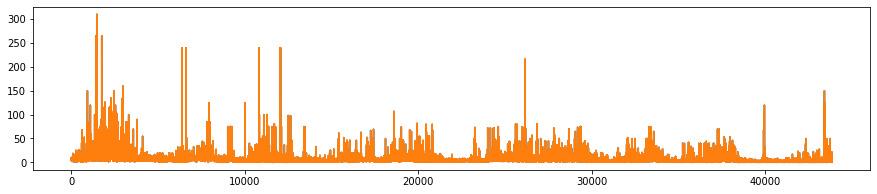

In [293]:
Y = prices['price_down'][1:]
X = prices['price_down'][:-1]

test_size = 1
test_cutoff = int((1-test_size)*len(Y))
Y_train = Y.iloc[:test_cutoff]
X_train = X.iloc[:test_cutoff]
Y_test = Y.iloc[test_cutoff:]
X_test = X.iloc[test_cutoff:]

assert len(Y_train) == len(X_train)
assert len(Y_test) == len(X_test)

Y_hat = []
for X in X_test:
    Y_hat.append(persistence_model(X))
    
print(mean_squared_error(Y_test, Y_hat))
fig = plt.figure(figsize = (15,3))
plt.plot(Y_hat)
plt.plot(Y_test)
plt.show() #graphing is pointless on this timescale

Trying a year at a time. Results are pretty interesting: 2014 was much more volatile than 2018 (each subsequent year is actually less volatile).

In [294]:
prices.head(1)

,date,hr_beg,price_down,price_up
0,2014-01-01,00:00:00,5.65,9.72


In [297]:
for year in [2014,2015,2016,2017,2018]:
    price_sub = prices.loc[(prices['date']>=datetime.date(year,1,1)) &
                           (prices['date']<=datetime.date(year,12,31)),'price_down']

    Y = price_sub[1:]
    X = price_sub[:-1]

    test_size = 1
    test_cutoff = int((1-test_size)*len(Y))
    Y_train = Y.iloc[:test_cutoff]
    X_train = X.iloc[:test_cutoff]
    Y_test = Y.iloc[test_cutoff:]
    X_test = X.iloc[test_cutoff:]

    assert len(Y_train) == len(X_train)
    assert len(Y_test) == len(X_test)

    Y_hat = []
    for X in X_test:
        Y_hat.append(persistence_model(X))

    print("MSE in "+str(year)+": "+str(mean_squared_error(Y_test, Y_hat)))

MSE in 2014: 192.5411313803716
MSE in 2015: 91.54681183114661
MSE in 2016: 57.88905978372226
MSE in 2017: 43.539966833998854
MSE in 2018: 32.56438231602967


OK, finally, a month at a time! Seems like we should be referencing a persistence model specific to whatever timeframe we're trying to predict over.

Results are also interesting, maybe helpful. Most interesting is that MSEs for summer months (I'm too lazy to graph this) are quite low compared to winter and spring--persistence model works well.

In [304]:
for year in [2014,2015,2016,2017,2018]:
    for month,day in zip(np.arange(1,13),[31,28,31,30,31,30,31,31,30,31,30,31]):
        price_sub = prices.loc[(prices['date']>=datetime.date(year,month,1)) &
                               (prices['date']<=datetime.date(year,month,day)),'price_down']

        Y = price_sub[1:]
        X = price_sub[:-1]

        test_size = 1
        test_cutoff = int((1-test_size)*len(Y))
        Y_train = Y.iloc[:test_cutoff]
        X_train = X.iloc[:test_cutoff]
        Y_test = Y.iloc[test_cutoff:]
        X_test = X.iloc[test_cutoff:]

        assert len(Y_train) == len(X_train)
        assert len(Y_test) == len(X_test)

        Y_hat = []
        for X in X_test:
            Y_hat.append(persistence_model(X))

        print("MSE in "+str(year)+", month "+str(month)+": "+str(mean_squared_error(Y_test, Y_hat)))

MSE in 2014, month 1: 36.618735127860035
MSE in 2014, month 2: 218.73679716840536
MSE in 2014, month 3: 705.354678032345
MSE in 2014, month 4: 524.8919936022253
MSE in 2014, month 5: 262.1721779273217
MSE in 2014, month 6: 39.91113671766342
MSE in 2014, month 7: 9.487181292059217
MSE in 2014, month 8: 11.667890174966352
MSE in 2014, month 9: 149.28906578581362
MSE in 2014, month 10: 151.31315598923283
MSE in 2014, month 11: 184.11417029972753
MSE in 2014, month 12: 17.614315343203227
MSE in 2015, month 1: 86.00036002691789
MSE in 2015, month 2: 40.43448986587183
MSE in 2015, month 3: 202.07809420485174
MSE in 2015, month 4: 135.009883310153
MSE in 2015, month 5: 361.09875814266485
MSE in 2015, month 6: 84.38309429763561
MSE in 2015, month 7: 35.13256191117093
MSE in 2015, month 8: 5.600709555854643
MSE in 2015, month 9: 10.567778998609178
MSE in 2015, month 10: 56.2344472409152
MSE in 2015, month 11: 22.17195785123967
MSE in 2015, month 12: 49.76372086137282
MSE in 2016, month 1: 9.158

## Trying to apply a harmonic function (#2) to deal w/ periodicity

First I'm going to try to figure out the period of the down-reg seasonal oscillation...by applying a moving average? Sure, why not.

https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

In [305]:
import statsmodels

Actually, let's come back to that. Let's do a daily thing first, instead.

In [325]:
price_sub = prices.loc[(prices['date']>=datetime.date(2016,4,1)) &
                               (prices['date']<=datetime.date(2016,4,10)),:'price_down'].reset_index(drop=True)

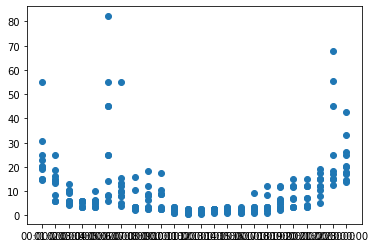

In [326]:
plt.plot(price_sub['hr_beg'],price_sub['price_down'], linestyle='none', marker='o')

It's surprisingly hard to tell what the period is of this data--a day? Less? It seems to be a day, ish, with a peak every night (around hour 0/24). Maybe I'll just try to fit a sine curve, and then move on to some smoothing with statsmodels.

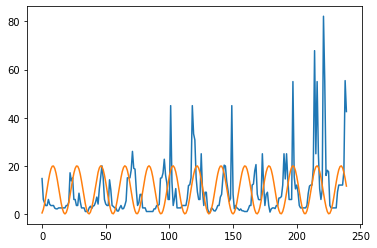

In [340]:
t = price_sub.index.to_list()
plt.plot(price_sub['price_down'])
plt.plot(10*np.sin(np.divide(t,3)+5)+10)

We're getting there. this is pure guesswork, though. is there a way to fit a sine curve without so much guessing? I guess figure out mathematically where each of the spikes is--then you've got the period, at least, and could bump up the whole thing to align the bottom with zero, and then use OLS to get the other parameter...

## Exploring statsmodels
Based on this: https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself.
A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.
Ideally, we want no correlation between the series and lags of itself. [I assume this is if you have successfully made the data stationary]

Trying it out--woah, cool. Also, what?! I was thinking that every 30 days there's serious autocorrelation...but it's like every 25 days?! This is baffling me a bit...

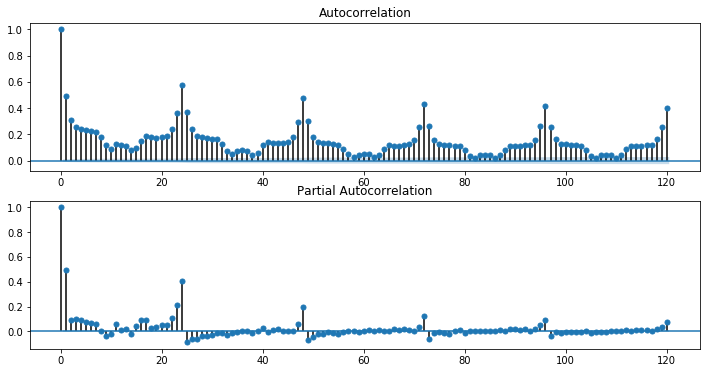

In [346]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(prices['price_down'].dropna(), ax=ax[0], lags=120)
ax[1] = plot_pacf(prices['price_down'].dropna(), ax=ax[1], lags=120)

Phew--just checking if random numbers would be autocorrelated due to something I'm not understanding about the math. No, duh.

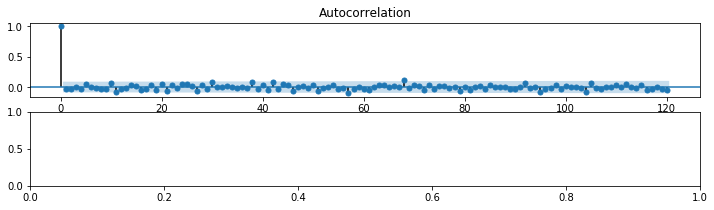

In [398]:
test_rand = np.random.normal(size=500)

fig, ax = plt.subplots(2, figsize=(12,3))
ax[0] = plot_acf(test_rand, ax=ax[0], lags=120)

In [355]:
corr = pd.DataFrame()
corr['acf'] = statsmodels.tsa.stattools.acf(prices['price_down'], nlags=120)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [359]:
corr['price'] = np.flip(prices['price_down'][:121]).reset_index(drop=True)

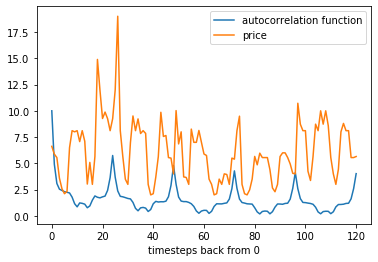

In [440]:
plt.plot(corr['acf']*10, label="autocorrelation function")
plt.plot(corr['price'], label='price')
plt.xlabel("timesteps back from 0")
plt.legend()

I guess I don't really understand why this is not at all lined up with the price history. Sense I'm missing something. At any rate, could get local mins and use that as the period for my sine function.

### Now actually exploring rolling means and de-trending
https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

In [371]:
prices_sub = prices.loc[:8760,:'price_down']

In [372]:
prices_sub

,date,hr_beg,price_down
0,2014-01-01,00:00:00,5.65
1,2014-01-01,01:00:00,5.55
2,2014-01-01,02:00:00,5.55
3,2014-01-01,03:00:00,8.11
4,2014-01-01,04:00:00,8.11
...,...,...,...
8756,2014-12-31,06:00:00,7.11
8757,2014-12-31,07:00:00,3.10
8758,2014-12-31,08:00:00,3.01
8759,2014-12-31,09:00:00,5.65


In [376]:
prices_sub['z_data'] = (prices_sub['price_down'] - prices_sub['price_down'].rolling(window=12).mean()) / prices_sub['price_down'].rolling(window=12).std()
prices_sub['zp_data'] = prices_sub['z_data'] - prices_sub['z_data'].shift(12)


In [382]:
prices_sub.rename(columns={'price_down':'data'}, inplace=True)

In [383]:
def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.data.rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df.data.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

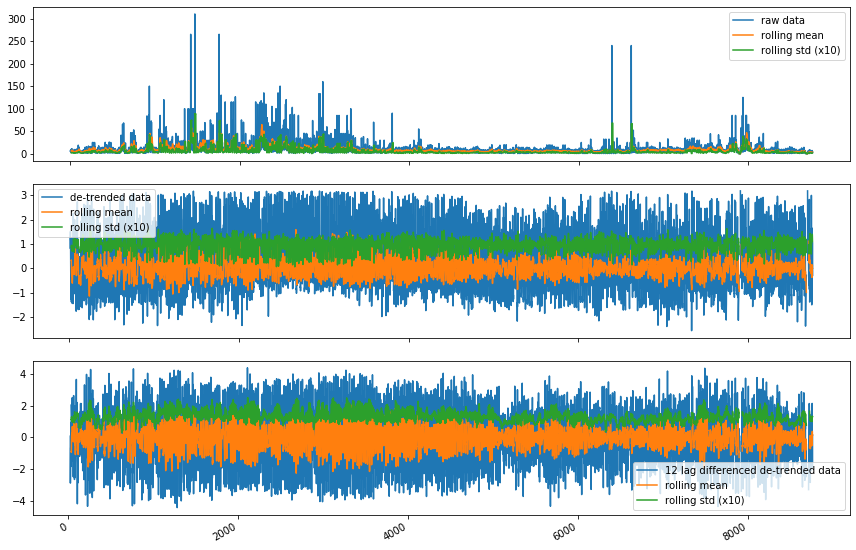

In [384]:
plot_rolling(prices_sub)

Testing if data is stationary. Now this is really bizarre, that it says the original data is stationary. Does that mean it's just random...?

In [386]:
from statsmodels.tsa.stattools import adfuller

df = prices_sub

print(" > Is the data stationary ?")
dftest = adfuller(df.data, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    

 > Is the data stationary ?
Test statistic = -8.085
P-value = 0.000
Critical values :
	1%: -3.4310995387302516 - The data is  stationary with 99% confidence
	5%: -2.861871246211382 - The data is  stationary with 95% confidence
	10%: -2.566946317391388 - The data is  stationary with 90% confidence


### Seasonal decomposition, specifically
https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051

with some help from: 
https://www.cbcity.de/timeseries-decomposition-in-python-with-statsmodels-and-pandas.

Cool! This worked pretty well. Still so much randomness it's unbelievable, but hey.

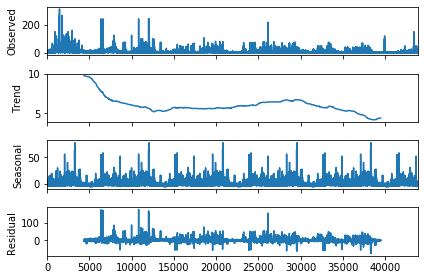

In [431]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_freq = 24*365
decomp_annual = seasonal_decompose(prices.loc[:,'price_down'], model='additive', freq=decomp_freq)
decomp_annual.plot()
plt.show()

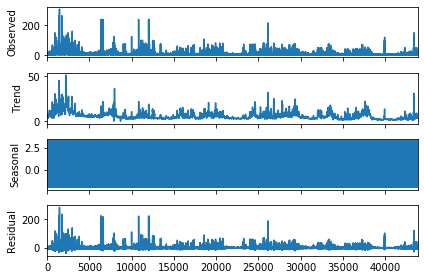

In [432]:
decomp_daily = seasonal_decompose(prices.loc[:,'price_down'], model='additive', freq=24)
decomp_daily.plot()
plt.show()

(0, 200)

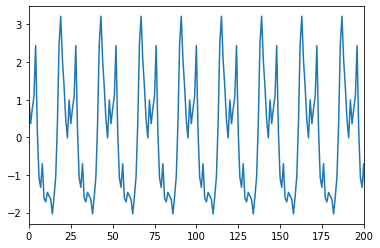

In [435]:
plt.plot(decomp_daily.seasonal)
plt.xlim([0,200])

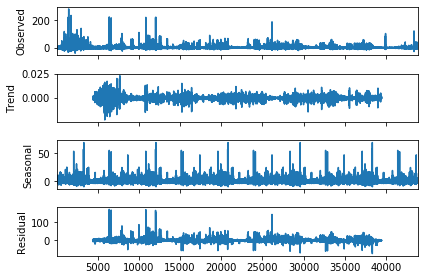

In [436]:
decomp_annual2 = seasonal_decompose(decomp_daily.resid.dropna(),model='additive',freq=8760)
decomp_annual2.plot()
plt.show()

(0, 8760)

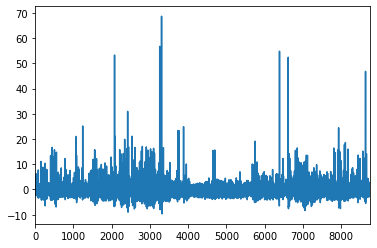

In [438]:
plt.plot(decomp_annual2.seasonal)
plt.xlim([0,8760])